<a href="https://colab.research.google.com/github/Rawan-Sotohy/GTC-Medical-Imaging-Tumor-Detection/blob/main/TumorDetection_DataPreparationPhase_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samasamer","key":"4baca4e6aaf98ce796326b55364f13f4"}'}

In [2]:
import os
import zipfile
# Make kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)
# Move kaggle.json
!mv kaggle.json /root/.kaggle/
# Change permissions
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 80% 119M/149M [00:00<00:00, 1.24GB/s]
100% 149M/149M [00:00<00:00, 1.09GB/s]


In [4]:
with zipfile.ZipFile("brain-tumor-mri-dataset.zip","r") as z:
    z.extractall("brain_tumor_dataset")

Data Preparation and Preprocessing

In [5]:
import sys
import configparser
import time
from math import ceil

# Reading and setup data
import cv2
import imutils
from tqdm import tqdm

# Loading datasets
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
import tensorflow as tf
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [7]:
train_dir = "brain_tumor_dataset/Training"
print("Subfolders inside Training:")
print(os.listdir(train_dir))

Subfolders inside Training:
['notumor', 'meningioma', 'glioma', 'pituitary']


Exploring Data

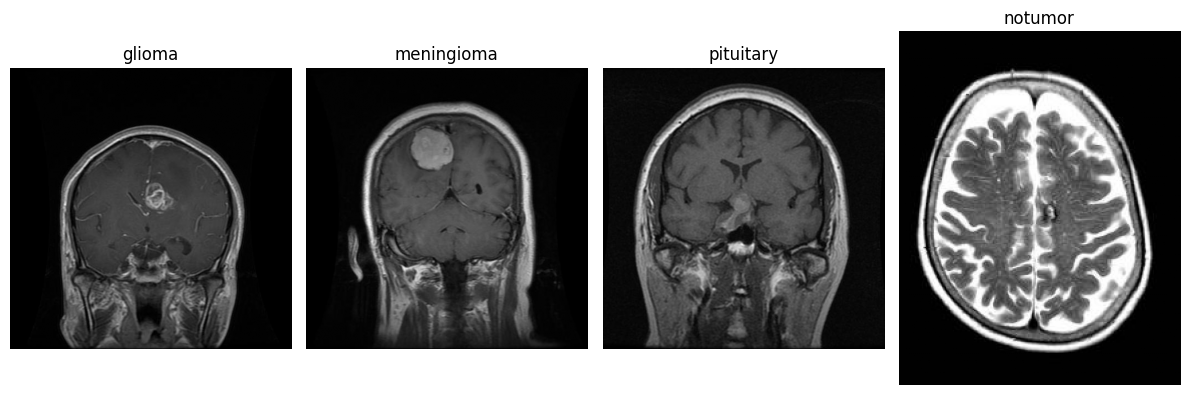

In [8]:
train_dir = "brain_tumor_dataset/Training"
categories = ["glioma", "meningioma", "pituitary", "notumor"]

plt.figure(figsize=(12, 4))

for i, category in enumerate(categories):
    class_folder = os.path.join(train_dir, category)
    files = os.listdir(class_folder)

    img_path = os.path.join(class_folder, files[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(category)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
import shutil
import random
from collections import Counter
# Paths
original_train_dir = "brain_tumor_dataset/Training"
original_test_dir  = "brain_tumor_dataset/Testing"
new_base_dir       = "brain_tumor_dataset_split"
train_dir          = os.path.join(new_base_dir, "train")
valid_dir          = os.path.join(new_base_dir, "valid")
test_dir           = os.path.join(new_base_dir, "test")
# Create new folders
for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)
# Copy test folder as-is
shutil.copytree(original_test_dir, test_dir, dirs_exist_ok=True)
# Split Training into train + validation
for class_name in os.listdir(original_train_dir):
    class_path = os.path.join(original_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    valid_images = images[split_idx:]

    # Create class folders in new train/valid dirs
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)

    # Copy files
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_dir, class_name, img))

# Function to count images per class
def count_images(base_dir):
    data = []
    for category in os.listdir(base_dir):
        folder = os.path.join(base_dir, category)
        if os.path.isdir(folder):
            count = len(os.listdir(folder))
            data.append([base_dir.split("/")[-1], category, count])
    return data

import pandas as pd

train_data = count_images(train_dir)
valid_data = count_images(valid_dir)
test_data  = count_images(test_dir)

df = pd.DataFrame(train_data + valid_data + test_data, columns=["Split", "Class", "Count"])
print(df)

    Split       Class  Count
0   train     notumor   1276
1   train  meningioma   1071
2   train      glioma   1056
3   train   pituitary   1165
4   valid     notumor    319
5   valid  meningioma    268
6   valid      glioma    265
7   valid   pituitary    292
8    test     notumor    405
9    test  meningioma    306
10   test      glioma    300
11   test   pituitary    300


Resizing And Normalizing Data

In [10]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Force 1 channel
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Apply this transform to the datasets
train_set = datasets.ImageFolder(train_dir, transform=transform)
valid_set = datasets.ImageFolder(valid_dir, transform=transform)
test_set  = datasets.ImageFolder(original_test_dir,  transform=transform)

# Test first image
img_train, label_train = train_set[0]
print("Train image type:", type(img_train))
print("Train image size:", img_train.shape)

img_valid, label_valid = valid_set[0]
print("Valid image type:", type(img_valid))
print("Valid image size:", img_valid.shape)

Train image type: <class 'torch.Tensor'>
Train image size: torch.Size([1, 128, 128])
Valid image type: <class 'torch.Tensor'>
Valid image size: torch.Size([1, 128, 128])


In [11]:
print(img_train.min(), img_train.max())

tensor(0.) tensor(0.8078)


In [12]:
print(img_valid.min(), img_valid.max())

tensor(0.) tensor(0.7569)


Data Augmentation

In [13]:
random_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=random_transform)

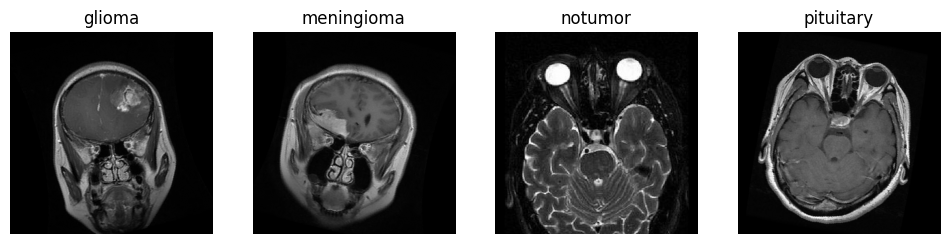

In [14]:
def imshow(img_tensor, ax, title=None):
    img = img_tensor[0, :, :]  # remove the single channel dimension
    ax.imshow(img, cmap='gray')
    if title:
        ax.set_title(title)
    ax.axis('off')

fig, axes = plt.subplots(1, 4, figsize=(12,3))
displayed_classes = set()
i = 0

for img, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name not in displayed_classes:
        imshow(img, axes[i], title=class_name)
        displayed_classes.add(class_name)
        i += 1
    if i == 4:
        break

plt.show()

# Exploratory Data Analysis + Feature Building

In [15]:
dataset_path = "brain_tumor_dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir  = os.path.join(dataset_path, "Testing")

labels = ["glioma", "meningioma", "pituitary", "notumor"]

**Count Images per Class**

In [16]:
files_path_dict = {}
num_images_per_label = []
label_names = []
num_testing_images = {}

for label in labels:
    train_path = os.path.join(dataset_path, "Training", label)
    test_path = os.path.join(dataset_path, "Testing", label)

    files_path_dict[label] = [os.path.join(train_path, x) for x in os.listdir(train_path)]
    num_testing_images[label] = len([os.path.join(test_path, x) for x in os.listdir(test_path)])

    num_images_per_label.append(len(files_path_dict[label]))
    label_names.append(label)

    print(f"Number of images in {label}: {len(files_path_dict[label])}")

Number of images in glioma: 1321
Number of images in meningioma: 1339
Number of images in pituitary: 1457
Number of images in notumor: 1595


**Pie Charts (Class & Split Distribution)**

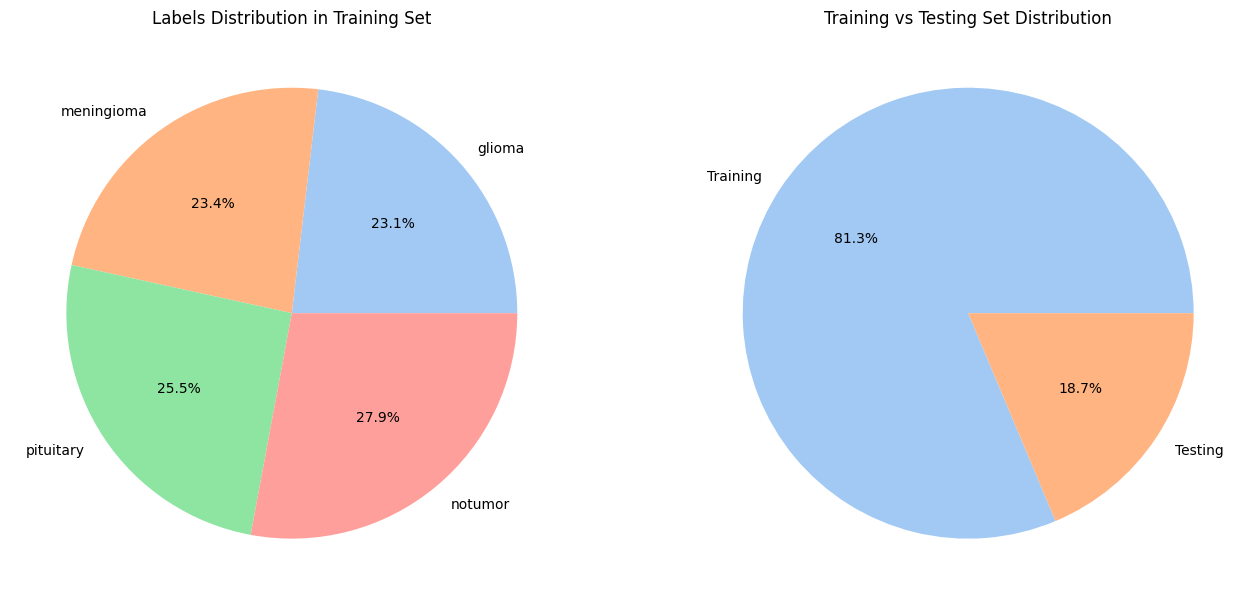

In [17]:
plt.figure(figsize=(16, 8))
colors = sns.color_palette('pastel')

# Training set distribution
plt.subplot(1, 2, 1)
plt.pie(num_images_per_label, labels=label_names, autopct='%1.1f%%', colors=colors)
plt.title('Labels Distribution in Training Set')

# Training vs Testing
plt.subplot(1, 2, 2)
plt.pie([sum(num_images_per_label), sum(num_testing_images.values())],
        labels=['Training', 'Testing'], autopct='%1.1f%%', colors=colors)
plt.title('Training vs Testing Set Distribution')

plt.show()

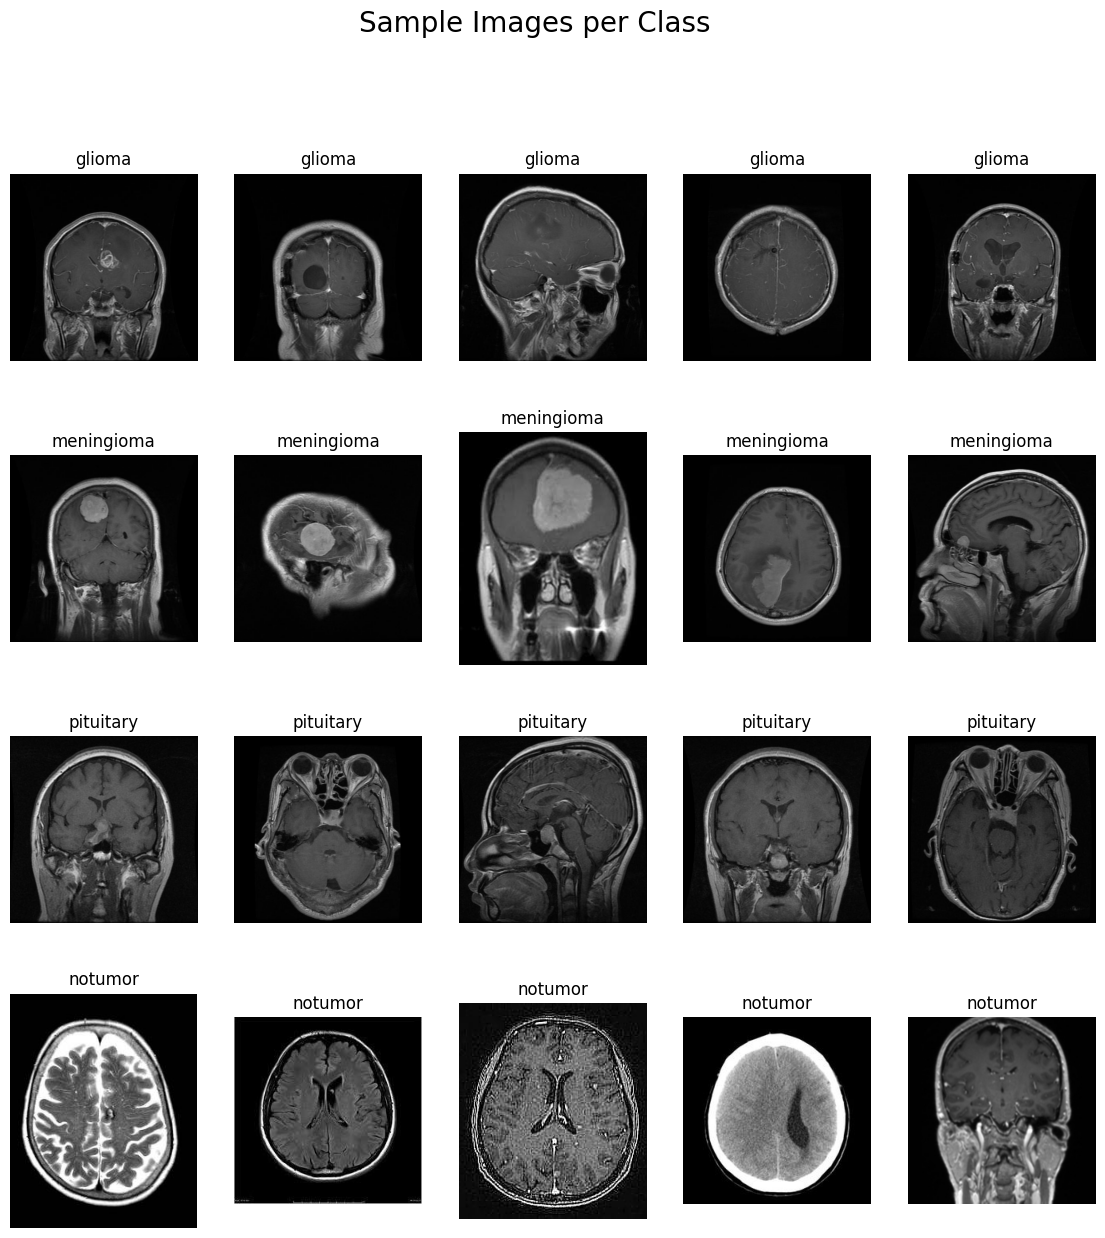

In [18]:
plt.figure(figsize=(14,14))
index = 0
for label in labels:
    path_list = files_path_dict[label][:5]
    for i in range(5):
        index += 1
        plt.subplot(len(labels), 5, index)
        img = cv2.imread(path_list[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
plt.suptitle("Sample Images per Class", fontsize=20)
plt.show()

**Image Dimensions Analysis**

Most common image sizes:
Height  Width  Channels
512     512    3           3955
225     225    3            268
630     630    3             77
236     236    3             53
251     201    3             43
Name: count, dtype: int64


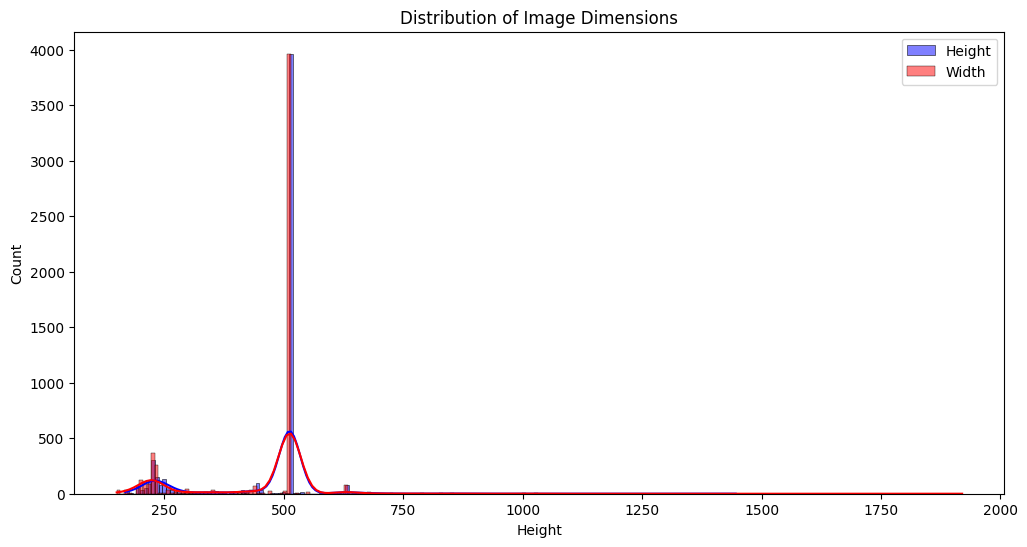

In [19]:
dims = []
for cls in labels:
    for img_file in files_path_dict[cls]:
        img = cv2.imread(img_file)
        if img is not None:
            dims.append(img.shape)

dims_df = pd.DataFrame(dims, columns=["Height","Width","Channels"])
print("Most common image sizes:")
print(dims_df.value_counts().head())

plt.figure(figsize=(12,6))
sns.histplot(dims_df["Height"], kde=True, color="blue", label="Height")
sns.histplot(dims_df["Width"], kde=True, color="red", label="Width")
plt.legend()
plt.title("Distribution of Image Dimensions")
plt.show()

**Pixel Intensity Distribution**

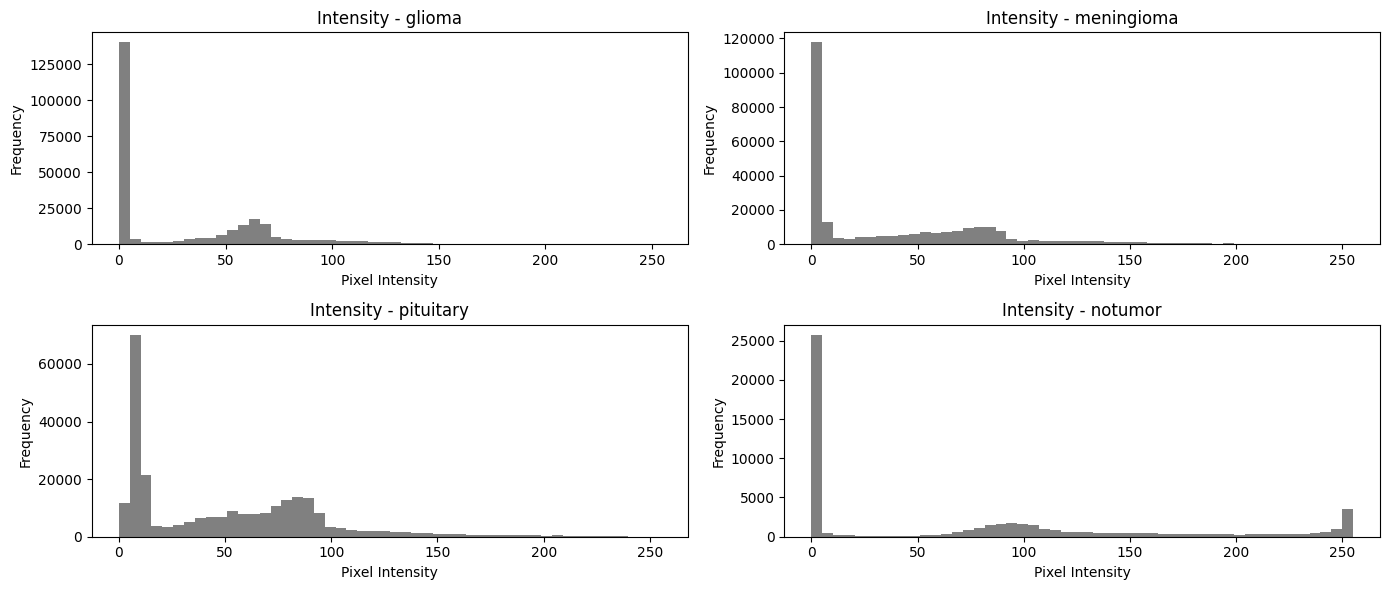

In [20]:
def plot_intensity_histogram(img_path, title):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.hist(img.ravel(), bins=50, color="gray")
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

plt.figure(figsize=(14,6))
for i, label in enumerate(labels):
    plt.subplot(2,2,i+1)
    plot_intensity_histogram(files_path_dict[label][0], f"Intensity - {label}")
plt.tight_layout()
plt.show()


**Feature Extraction (Mean, Std Intensity)**

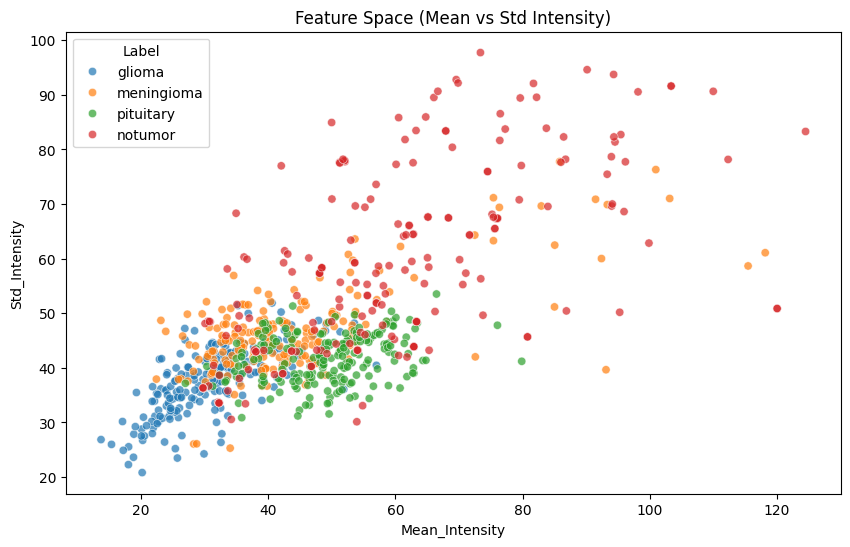

In [21]:
feature_data = []
for label in labels:
    for img_file in files_path_dict[label][:200]: # limit for speed
        img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        feature_data.append([img.mean(), img.std(), label])

features_df = pd.DataFrame(feature_data, columns=["Mean_Intensity","Std_Intensity","Label"])

plt.figure(figsize=(10,6))
sns.scatterplot(data=features_df, x="Mean_Intensity", y="Std_Intensity", hue="Label", alpha=0.7)
plt.title("Feature Space (Mean vs Std Intensity)")
plt.show()


**Correlation Heatmap**

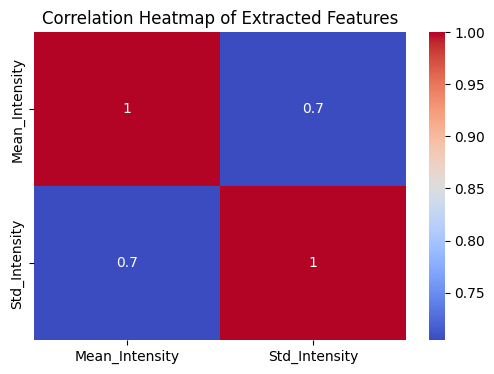

In [22]:
plt.figure(figsize=(6,4))
sns.heatmap(features_df.drop("Label", axis=1).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Extracted Features")
plt.show()

**Class Balance Barplot**

/tmp/ipython-input-2498020993.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=num_images_per_label, palette="pastel")


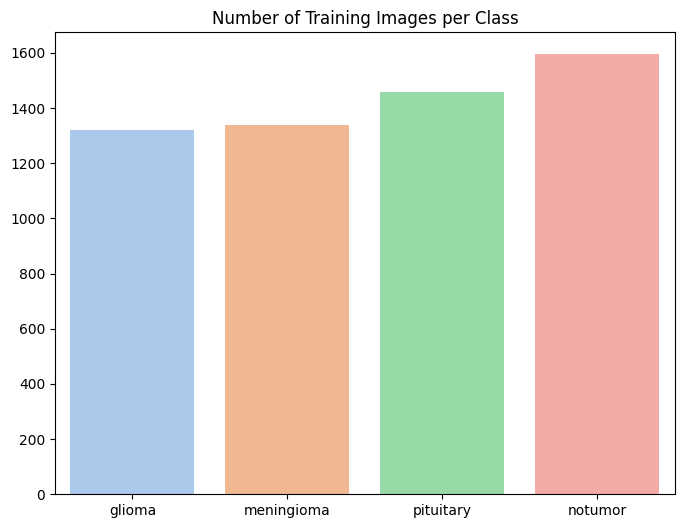

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(x=label_names, y=num_images_per_label, palette="pastel")
plt.title("Number of Training Images per Class")
plt.show()

**Augmentation Visualization**

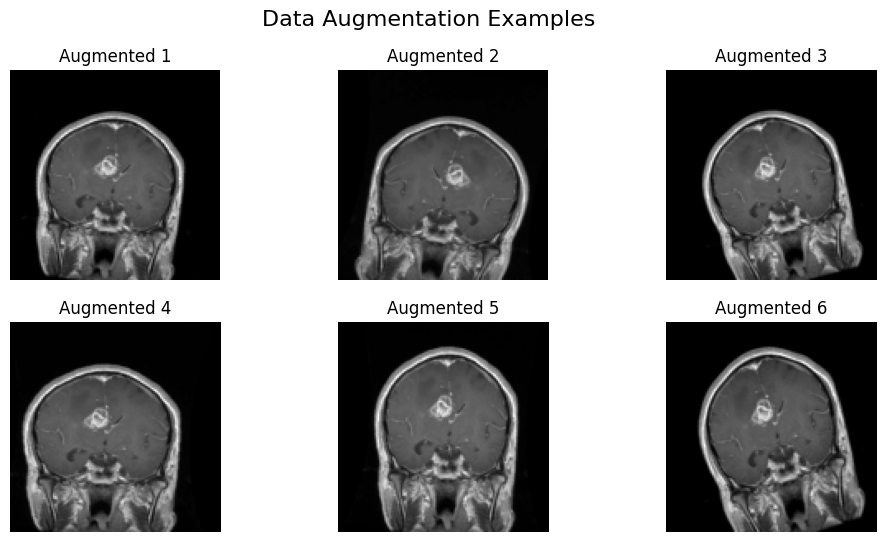

In [24]:
import torchvision.transforms as T
from PIL import Image

# Example transformations
transformations = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.3, contrast=0.3),
    T.RandomResizedCrop(128, scale=(0.8, 1.0)),
])

# Pick one sample image
sample_img_path = files_path_dict["glioma"][0]
img = Image.open(sample_img_path)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    aug_img = transformations(img)
    plt.imshow(aug_img, cmap="gray")
    plt.axis("off")
    plt.title(f"Augmented {i+1}")
plt.suptitle("Data Augmentation Examples", fontsize=16)
plt.show()

**PCA Visualization of Features**

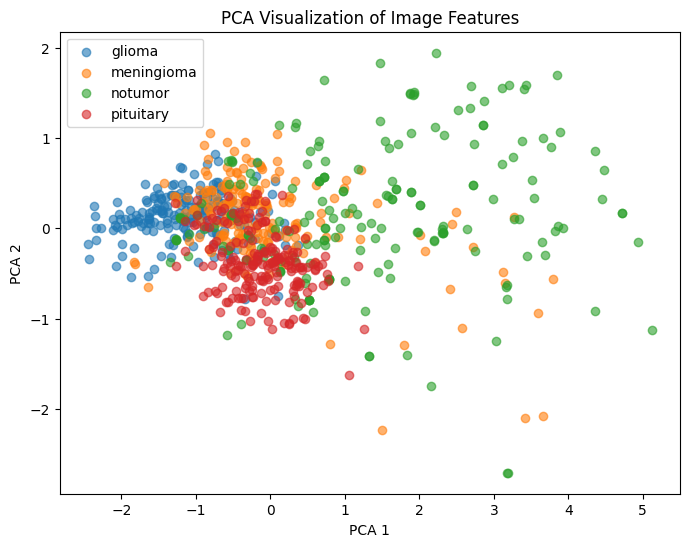

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data
X = features_df[["Mean_Intensity","Std_Intensity"]].values
y = features_df["Label"].values

# Scale + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(y):
    plt.scatter(X_pca[y==label,0], X_pca[y==label,1], label=label, alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Visualization of Image Features")
plt.legend()
plt.show()

**t-SNE Visualization**

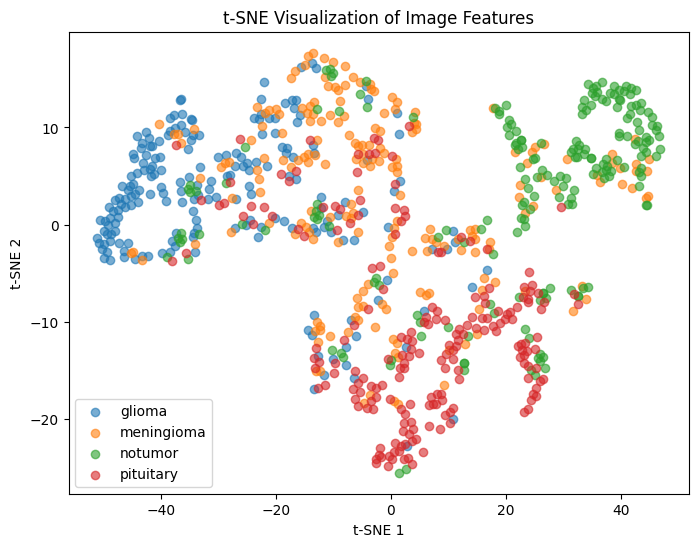

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for label in np.unique(y):
    plt.scatter(X_tsne[y==label,0], X_tsne[y==label,1], label=label, alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Image Features")
plt.legend()
plt.show()

**Intensity Histograms per Class**

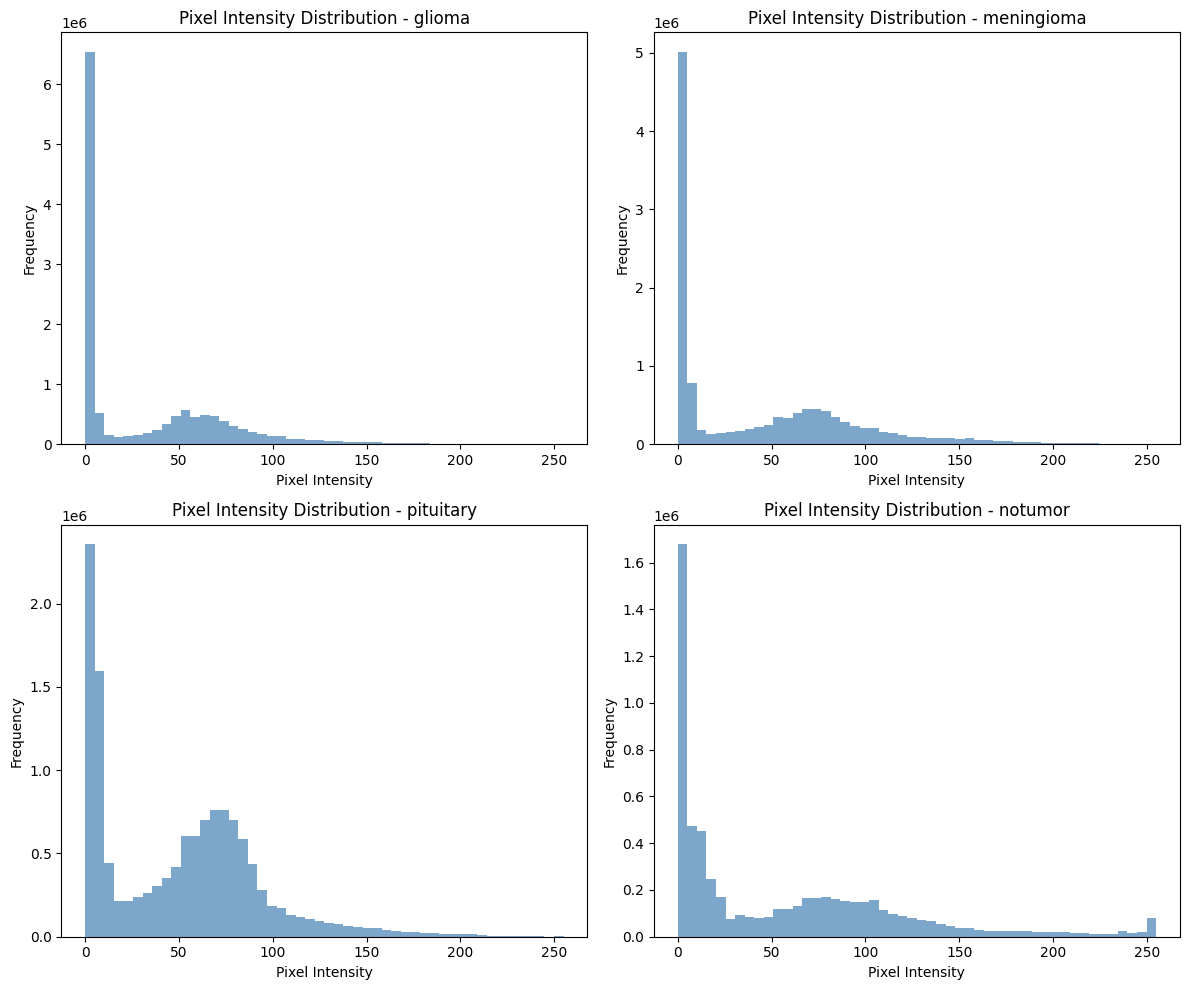

In [27]:
plt.figure(figsize=(12, 10))

for i, label in enumerate(labels):
    class_images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in files_path_dict[label][:50]]
    pixel_values = np.concatenate([img.flatten() for img in class_images])

    plt.subplot(2, 2, i+1)   # بدل 1,2 بخليها 2,2
    plt.hist(pixel_values, bins=50, color='steelblue', alpha=0.7)
    plt.title(f"Pixel Intensity Distribution - {label}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Boxplot**

/tmp/ipython-input-774236733.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="Mean_Intensity", data=df_means, palette="pastel")


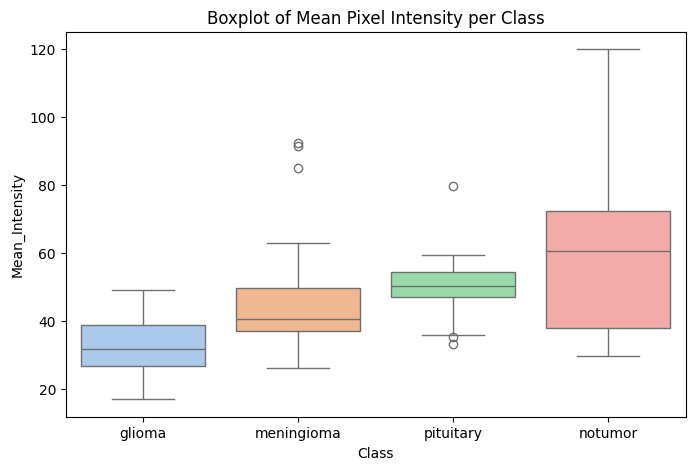

/tmp/ipython-input-774236733.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Class", y="Mean_Intensity", data=df_means, palette="muted")


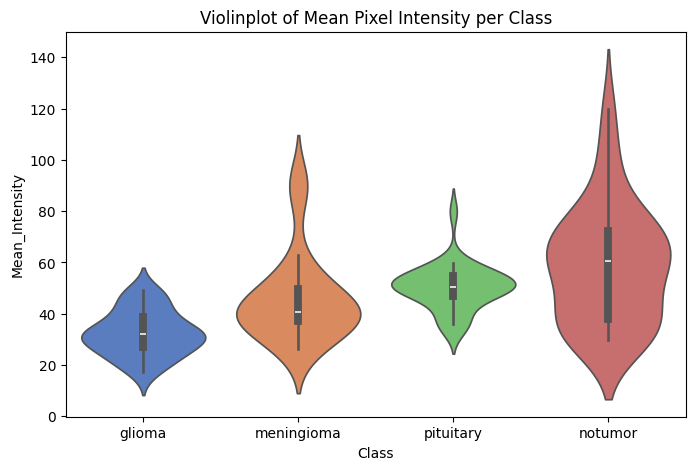

In [28]:
data = []
for label in labels:
    class_images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in files_path_dict[label][:30]]
    means = [np.mean(img) for img in class_images]
    data.extend([(m, label) for m in means])

df_means = pd.DataFrame(data, columns=["Mean_Intensity", "Class"])

plt.figure(figsize=(8, 5))
sns.boxplot(x="Class", y="Mean_Intensity", data=df_means, palette="pastel")
plt.title("Boxplot of Mean Pixel Intensity per Class")
plt.show()

plt.figure(figsize=(8, 5))
sns.violinplot(x="Class", y="Mean_Intensity", data=df_means, palette="muted")
plt.title("Violinplot of Mean Pixel Intensity per Class")
plt.show()


**Feature Extraction (Mean, Std) + Correlation**

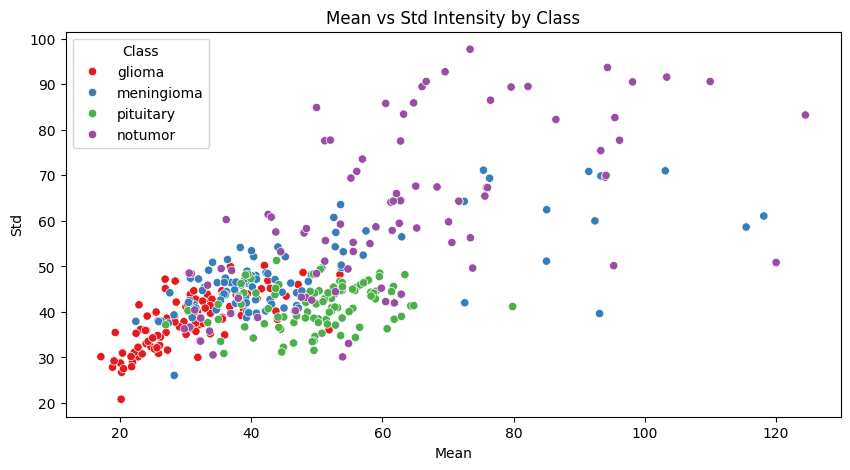

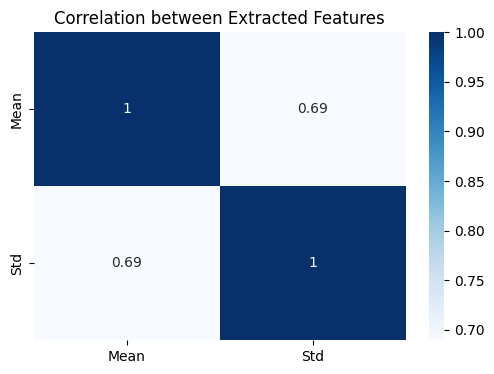

In [29]:
# Extract simple features (mean, std) for each image
features = []

for label in labels:
    for img_path in files_path_dict[label][:100]:  # خدي 100 صورة بس عشان الوقت
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mean_val = np.mean(img)
        std_val = np.std(img)
        features.append([mean_val, std_val, label])

df_features = pd.DataFrame(features, columns=["Mean", "Std", "Class"])

# Plot distributions
plt.figure(figsize=(10, 5))
sns.scatterplot(x="Mean", y="Std", hue="Class", data=df_features, palette="Set1")
plt.title("Mean vs Std Intensity by Class")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_features.drop(columns=["Class"]).corr(), annot=True, cmap="Blues")
plt.title("Correlation between Extracted Features")
plt.show()


**feature engineering**

In [31]:
#Texture Features (GLCM)
from skimage.feature import graycomatrix, graycoprops

glcm_features = []

for label in labels:
    for img_path in files_path_dict[label][:50]:  # limit to 50 per class for speed
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # GLCM calculation
        glcm = graycomatrix(img_resized, [1], [0], symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        glcm_features.append([contrast, energy, homogeneity, correlation, label])

df_glcm = pd.DataFrame(glcm_features, columns=["Contrast","Energy","Homogeneity","Correlation","Class"])
print(df_glcm.head())


     Contrast    Energy  Homogeneity  Correlation   Class
0  350.000492  0.261247     0.547074     0.886156  glioma
1  205.154774  0.299583     0.593263     0.946491  glioma
2  392.192913  0.136369     0.398894     0.895088  glioma
3  223.063976  0.346941     0.642752     0.924995  glioma
4  325.458538  0.257181     0.543784     0.885175  glioma


Gray-Level Co-occurrence Matrix (GLCM) measures how often pairs of pixels with specific values occur at a certain distance.

From this, we extract contrast, energy, homogeneity, correlation → useful for tumor texture patterns.
Contrast

Measures the difference between neighboring pixel intensities.

High contrast → more variation in texture (tumor edges, irregular regions).

Low contrast → smoother regions (healthy tissue).
Energy (a.k.a. Angular Second Moment)

Measures uniformity or repetition in the image.

Range: [0,1], higher = more regular/repetitive texture.

Tumors often have lower energy because texture is irregular.
Homogeneity

Measures closeness of pixel distribution to the diagonal in the GLCM.

High value → pixels are similar (smooth textures).

Low value → many sharp transitions (edges, tumor boundaries).

In [32]:
#part2:Local Binary Patterns (LBP)

from skimage.feature import local_binary_pattern

lbp_features = []

for label in labels:
    for img_path in files_path_dict[label][:50]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # LBP
        lbp = local_binary_pattern(img_resized, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)

        lbp_features.append(list(lbp_hist) + [label])

df_lbp = pd.DataFrame(lbp_features, columns=[f"LBP_{i}" for i in range(10)] + ["Class"])
print(df_lbp.head())


      LBP_0     LBP_1     LBP_2     LBP_3     LBP_4     LBP_5     LBP_6  \
0  0.041870  0.051392  0.025757  0.057007  0.080566  0.086304  0.038879   
1  0.027344  0.039124  0.023987  0.060425  0.104370  0.091919  0.032410   
2  0.056396  0.072693  0.034119  0.069031  0.121582  0.116150  0.056396   
3  0.034241  0.046448  0.018616  0.040405  0.067810  0.071777  0.033386   
4  0.043823  0.058167  0.027405  0.053040  0.072571  0.081726  0.043701   

      LBP_7     LBP_8     LBP_9   Class  
0  0.066406  0.462036  0.089783  glioma  
1  0.047119  0.514282  0.059021  glioma  
2  0.090576  0.258301  0.124756  glioma  
3  0.055847  0.550842  0.080627  glioma  
4  0.066711  0.455017  0.097839  glioma  


LBP works by comparing each pixel with its 8 neighbors in a circle (P=8, R=1 in your case).

Each pixel gets a binary code based on whether the neighbor is darker or lighter.

These binary codes are then grouped into patterns (uniform patterns).       
LBP_8 dominates (40–55%), the region is homogeneous (smooth tissue).

If other bins (LBP_0–7,9) increase, the texture is more irregular (edges, corners, tumor structures).


In [33]:
#part3: HOG (Histogram of Oriented Gradients)
from skimage.feature import hog

hog_features = []

for label in labels:
    for img_path in files_path_dict[label][:30]:  # fewer images (HOG is heavy)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # HOG
        hog_feat, _ = hog(img_resized, pixels_per_cell=(16, 16),
                          cells_per_block=(2, 2), visualize=True, feature_vector=True)

        hog_features.append(list(hog_feat[:50]) + [label])  # take first 50 for demo

df_hog = pd.DataFrame(hog_features, columns=[f"HOG_{i}" for i in range(50)] + ["Class"])
print(df_hog.head())


      HOG_0     HOG_1     HOG_2     HOG_3     HOG_4     HOG_5     HOG_6  \
0  0.285547  0.049447  0.203275  0.024723  0.285547  0.000000  0.285547   
1  0.217260  0.000000  0.085348  0.000000  0.289680  0.053979  0.187765   
2  0.008443  0.000787  0.006965  0.003146  0.016534  0.001573  0.003980   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.298749  0.064760  0.000000  0.175312  0.298749  0.000000  0.298749   

      HOG_7  HOG_8     HOG_9  ...    HOG_41    HOG_42    HOG_43  HOG_44  \
0  0.197788    0.0  0.285547  ...  0.000000  0.135612  0.000000     0.0   
1  0.134947    0.0  0.120700  ...  0.000000  0.102460  0.000000     0.0   
2  0.000000    0.0  0.012664  ...  0.000362  0.001833  0.000000     0.0   
3  0.000000    0.0  0.344134  ...  0.000000  0.004594  0.004842     0.0   
4  0.116971    0.0  0.130327  ...  0.006070  0.013437  0.000000     0.0   

     HOG_45    HOG_46    HOG_47    HOG_48    HOG_49   Class  
0  0.187219  0.000000  0.116239  0.0

This table is the HOG feature representation of THE images. Each number describes how strong edges are in a particular direction in a small patch of the image. Together, these numbers form a "fingerprint" of the tumor’s structure. The Class column is the ground-truth label you want to predict.

In [34]:
#part4: shape features:
shape_features = []

for label in labels:
    for img_path in files_path_dict[label][:50]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # Threshold
        _, thresh = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)  # largest contour
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            circularity = (4 * np.pi * area) / (perimeter**2 + 1e-5)  # avoid div 0
        else:
            area, perimeter, circularity = 0, 0, 0

        shape_features.append([area, perimeter, circularity, label])

df_shape = pd.DataFrame(shape_features, columns=["Area","Perimeter","Circularity","Class"])
print(df_shape.head())


     Area   Perimeter  Circularity   Class
0  7005.0  484.132031     0.375570  glioma
1  5990.0  444.333042     0.381258  glioma
2  9453.0  397.019333     0.753627  glioma
3  5544.0  281.906635     0.876642  glioma
4  6658.5  450.575681     0.412146  glioma


This table represents shape features of tumors.
Area tells how big the tumor is,
Perimeter tells how long/complex the boundary is,
Circularity tells how round or irregular the tumor is.
The Class is the diagnosis label (glioma).

In [35]:
#Part 5 – Deep Features (Pretrained CNN)
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load pretrained ResNet
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # remove last FC layer
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

deep_features = []

for label in labels:
    for img_path in files_path_dict[label][:10]:  # just 10 per class for demo
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            feat = resnet(input_tensor).flatten().numpy()
        deep_features.append(list(feat) + [label])

df_deep = pd.DataFrame(deep_features)
print("Deep features shape:", df_deep.shape)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


Deep features shape: (40, 513)


Instead of hand-crafted features, use a pretrained model (ResNet, VGG, EfficientNet).

Extract high-level features from MRIs automatically.

In [36]:
#combining all featrues: Example merge (only small ones for demo)
df_all = df_glcm.merge(df_shape, on="Class", how="inner")
df_all = df_all.merge(df_lbp, on="Class", how="inner")

print("Final Combined Features:", df_all.shape)
print(df_all.head())


Final Combined Features: (500000, 18)
     Contrast    Energy  Homogeneity  Correlation   Class    Area   Perimeter  \
0  350.000492  0.261247     0.547074     0.886156  glioma  7005.0  484.132031   
1  350.000492  0.261247     0.547074     0.886156  glioma  7005.0  484.132031   
2  350.000492  0.261247     0.547074     0.886156  glioma  7005.0  484.132031   
3  350.000492  0.261247     0.547074     0.886156  glioma  7005.0  484.132031   
4  350.000492  0.261247     0.547074     0.886156  glioma  7005.0  484.132031   

   Circularity     LBP_0     LBP_1     LBP_2     LBP_3     LBP_4     LBP_5  \
0      0.37557  0.041870  0.051392  0.025757  0.057007  0.080566  0.086304   
1      0.37557  0.027344  0.039124  0.023987  0.060425  0.104370  0.091919   
2      0.37557  0.056396  0.072693  0.034119  0.069031  0.121582  0.116150   
3      0.37557  0.034241  0.046448  0.018616  0.040405  0.067810  0.071777   
4      0.37557  0.043823  0.058167  0.027405  0.053040  0.072571  0.081726   

      

**summary of feature engineering:**
GLCM → texture relationships

LBP → micro-textures

HOG → shape/edges

Shape features → area, perimeter, circularity

Deep CNN features → learned representations

Merge → full feature set